In [1]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
yf.pdr_override()
from datetime import datetime
import copy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import data_util  
from sklearn.preprocessing import MinMaxScaler

In [2]:
from Evaluation_metrics import *
def evaluate_metrics(y_true, y_pred):
    results = {
        'Metric': ['MAPE', 'MAE', 'MSE', 'RMSE', 'R2', 'SMAPE'],
        'Value': [MAPE(y_true, y_pred), 
                  MAE(y_true, y_pred), 
                  MSE(y_true, y_pred), 
                  RMSE(y_true, y_pred), 
                  R2(y_true, y_pred), 
                  SMAPE(y_true, y_pred)]
    }
    df = pd.DataFrame(results)
    
    # Add dotted lines
    dotted_style = [dict(selector="th", props=[("border-bottom", "1px dotted #aaaaaa")]),
                    dict(selector="td", props=[("border-bottom", "1px dotted #aaaaaa")])]
    
    # Apply styling
    styled_df = (df.style
                 .set_properties(**{'text-align': 'center'})
                 .format({'Value': '{:.2f}'})  # Round values to 2 decimal places
                 .set_table_styles(dotted_style)
                 .set_caption('Evaluation Metrics')
                 .set_table_attributes('style="border-collapse: collapse; border: none;"')
                 .set_properties(subset=['Metric'], **{'font-weight': 'bold',}))  # Bold and blue headers
    
    return styled_df

from keras.callbacks import Callback

# Custom callback to display output every 'n' epochs
class VerboseEveryN(Callback):
    def __init__(self, n=5):
        super(VerboseEveryN, self).__init__()
        self.n = n

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.n == 0:
            print(f"Epoch {epoch+1} - {logs}")

In [3]:
def split_data(data,percent_split):
    size=(int((np.shape(data)[0])*(percent_split/100)))
    return data[0:size], data[size:]
def create_dataset(data , step):
    x,y=[],[]
    for i in range((data.shape[0])-step-1):
    
        x.append((data[i:i+step].values.tolist()))
        y.append(data['Close'][data['Close'].index[0]+i+step])
        # y.append(data[i+step]['Close'])


    return np.array(x),np.array(y)


def make_model(step ,numOfStacks, num_neurons):
    model=Sequential()
    model.add(LSTM(num_neurons[0],return_sequences=True,input_shape=(step,6)))
    for i in range(1,numOfStacks-1):
        model.add(LSTM(num_neurons[i],return_sequences=True))
    model.add(LSTM(num_neurons[-1]))
    
    model.add(Dense(1))
    return model

In [4]:
def MultiLstm(stock,epochs=100,step=100,numOfStacks=3,num_neurons=[128,128,50]):
    cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    fit = MinMaxScaler(feature_range=(0, 1))
    fit_close = MinMaxScaler(feature_range=(0, 1))

    scaled_data = pd.DataFrame()
    for col in cols:
        if (col=='Close'):
            scaled_col = fit_close.fit_transform(stock[col].values.reshape(-1, 1))
            scaled_data[col] = scaled_col.flatten()
        else:
            scaled_col = fit.fit_transform(stock[col].values.reshape(-1, 1))
            scaled_data[col] = scaled_col.flatten()
    # print(scaled_data)
    train_data,test_data=split_data(scaled_data, 70)
    # step = 100
    x_train, y_train = create_dataset(train_data, step)
    x_test, y_test = create_dataset(test_data, step)

    model=make_model(step , numOfStacks,num_neurons)
    model.compile(loss='mean_squared_error',optimizer='adam')
    # model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=epochs,batch_size=128,verbose=2)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=128, verbose=0, callbacks=[VerboseEveryN(epochs/10)])

    train_predict=model.predict(x_train)
    test_predict=model.predict(x_test)    

    train_predict=fit_close.inverse_transform(train_predict)
    test_predict=fit_close.inverse_transform(test_predict)
    y_test=fit_close.inverse_transform(y_test.reshape(-1,1))


    data=np.array(list(stock['Close'])).reshape(-1,1)
    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    # print(testPredictPlot)
    testPredictPlot[len(train_predict)+(step*2)+1:len(stock['Close'])-1] = test_predict
    # Plot the actual data in blue and the predicted data in red
    plt.plot(stock['Close'].values[:len(train_data)+len(data)-len(test_predict)-len(train_data)], color='blue', label='Actual Price')
    plt.plot(range(len(train_data)+len(data)-len(test_predict)-len(train_data),len(data)),stock['Close'].values[len(train_data)+len(data)-len(test_predict)-len(train_data):], color='red', label='Test data Price')
    plt.plot(testPredictPlot, color='orange', label='Predicted Price')
    plt.legend()
    plt.show()

    return test_predict,y_test

    

[*********************100%%**********************]  1 of 1 completed





Epoch 1 - {'loss': 0.0970936194062233, 'val_loss': 0.03650723025202751}
Epoch 11 - {'loss': 0.003144811140373349, 'val_loss': 0.0037771109491586685}
Epoch 21 - {'loss': 0.0026291999965906143, 'val_loss': 0.0028299526311457157}
Epoch 31 - {'loss': 0.0023031930904835463, 'val_loss': 0.002266543684527278}
Epoch 41 - {'loss': 0.002073250710964203, 'val_loss': 0.003618045710027218}
Epoch 51 - {'loss': 0.0019213929772377014, 'val_loss': 0.00391458859667182}
Epoch 61 - {'loss': 0.0018299297662451863, 'val_loss': 0.0016048491233959794}
Epoch 71 - {'loss': 0.0016254980582743883, 'val_loss': 0.0018707282142713666}
Epoch 81 - {'loss': 0.0013759807916358113, 'val_loss': 0.0012864557793363929}
Epoch 91 - {'loss': 0.0016943801892921329, 'val_loss': 0.0014921827241778374}
7/7 [==============================] - 0s 32ms/step


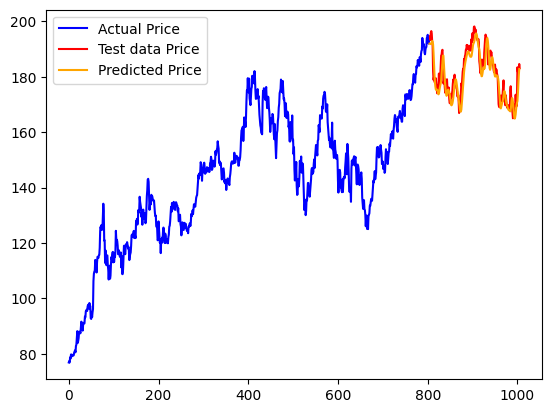

,Metric,Value
0,MAPE,1.83
1,MAE,3.32
2,MSE,16.91
3,RMSE,4.11
4,R2,0.77
5,SMAPE,1.84


In [5]:
a_stocks=data_util.stock_data('AAPL',4,'Apple')
y_pred,y_true=MultiLstm(a_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df


[*********************100%%**********************]  1 of 1 completed


Epoch 1 - {'loss': 0.08166670054197311, 'val_loss': 0.020931608974933624}
Epoch 11 - {'loss': 0.00240957154892385, 'val_loss': 0.004210656508803368}
Epoch 21 - {'loss': 0.0020261111203581095, 'val_loss': 0.001818963559344411}
Epoch 31 - {'loss': 0.0017209472134709358, 'val_loss': 0.0012791723711416125}
Epoch 41 - {'loss': 0.0016743165906518698, 'val_loss': 0.0012956972932443023}
Epoch 51 - {'loss': 0.0014407564885914326, 'val_loss': 0.000938508368562907}
Epoch 61 - {'loss': 0.0013119872892275453, 'val_loss': 0.0008390442817471921}
Epoch 71 - {'loss': 0.0012100636959075928, 'val_loss': 0.0007786975475028157}
Epoch 81 - {'loss': 0.0011288634268566966, 'val_loss': 0.0007490154821425676}
Epoch 91 - {'loss': 0.0010895620798692107, 'val_loss': 0.0006330403266474605}
7/7 [==============================] - 0s 31ms/step


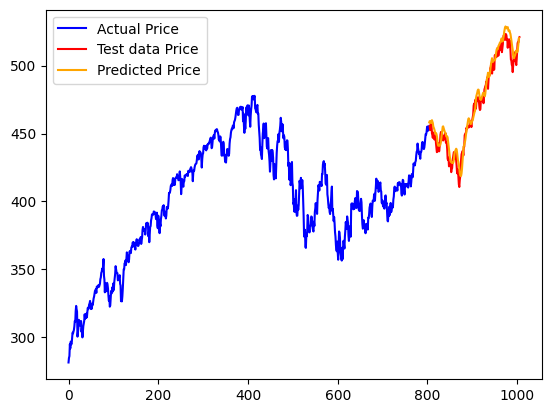

,Metric,Value
0,MAPE,1.14
1,MAE,5.29
2,MSE,44.22
3,RMSE,6.65
4,R2,0.96
5,SMAPE,1.13


In [6]:
s_stocks=data_util.stock_data('SPY', 4,'SPY')
y_pred,y_true=MultiLstm(s_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df

[*********************100%%**********************]  1 of 1 completed


Epoch 1 - {'loss': 0.10538579523563385, 'val_loss': 0.025659751147031784}
Epoch 11 - {'loss': 0.001037520356476307, 'val_loss': 0.009815423749387264}
Epoch 21 - {'loss': 0.000838970358017832, 'val_loss': 0.008663728833198547}
Epoch 31 - {'loss': 0.0008041700348258018, 'val_loss': 0.008188133127987385}
Epoch 41 - {'loss': 0.0007632037741132081, 'val_loss': 0.006216877605766058}
Epoch 51 - {'loss': 0.0007353489054366946, 'val_loss': 0.0050030662678182125}
Epoch 61 - {'loss': 0.0007009683176875114, 'val_loss': 0.0031925824005156755}
Epoch 71 - {'loss': 0.0006659243372268975, 'val_loss': 0.0019392857793718576}
Epoch 81 - {'loss': 0.0006224725511856377, 'val_loss': 0.0031373477540910244}
Epoch 91 - {'loss': 0.0006488030776381493, 'val_loss': 0.0034109754487872124}
7/7 [==============================] - 0s 32ms/step


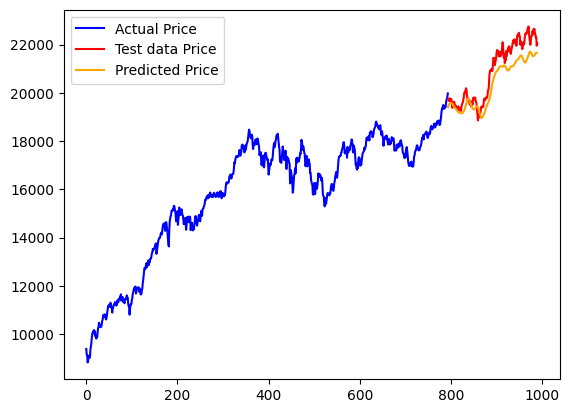

,Metric,Value
0,MAPE,2.52
1,MAE,538.22
2,MSE,398314.17
3,RMSE,631.12
4,R2,0.73
5,SMAPE,2.56


In [7]:
n_stocks=data_util.stock_data('^NSEI', 4,'Nifty 50')
y_pred,y_true=MultiLstm(n_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df

[*********************100%%**********************]  1 of 1 completed


Epoch 1 - {'loss': 0.15045753121376038, 'val_loss': 0.005232515744864941}
Epoch 11 - {'loss': 0.0027605167124420404, 'val_loss': 0.0016773935640230775}
Epoch 21 - {'loss': 0.002173650311306119, 'val_loss': 0.0014053218765184283}
Epoch 31 - {'loss': 0.002045128960162401, 'val_loss': 0.0010310423094779253}
Epoch 41 - {'loss': 0.001844183774664998, 'val_loss': 0.0008338507614098489}
Epoch 51 - {'loss': 0.0019227798329666257, 'val_loss': 0.0008003844995982945}
Epoch 61 - {'loss': 0.0016289451159536839, 'val_loss': 0.0009393516811542213}
Epoch 71 - {'loss': 0.0018501186277717352, 'val_loss': 0.0007711009820923209}
Epoch 81 - {'loss': 0.0013890519039705396, 'val_loss': 0.0007015128503553569}
Epoch 91 - {'loss': 0.0013966868864372373, 'val_loss': 0.001189253176562488}
7/7 [==============================] - 0s 35ms/step


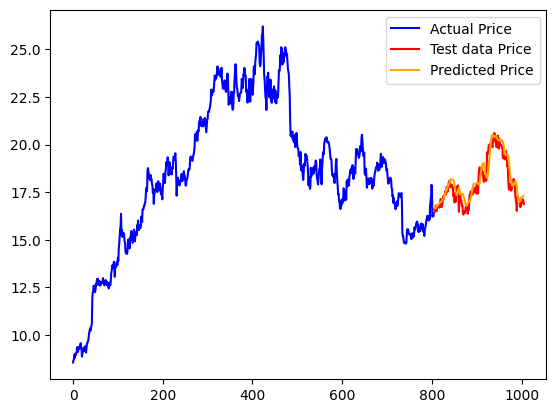

,Metric,Value
0,MAPE,2.03
1,MAE,0.36
2,MSE,0.23
3,RMSE,0.48
4,R2,0.83
5,SMAPE,2.01


In [8]:
i_stocks=data_util.stock_data('INFY', 4,'Infosys')
y_pred,y_true=MultiLstm(i_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df